In [ ]:
import os

# Set the OpenAI API key as an environment variable
os.environ["OPENAI_API_KEY"] = ""

In [5]:
!pip install --upgrade langchain_community

  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
Using cached langchain_community-0.4.1-py3-none-any.whl (2.5 MB)
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
Using cached httpx_sse-0.4.3-py3-none-any.whl (9.0 kB)
Using cached langchain_classic-1.0.0-py3-none-any.whl (1.0 MB)
Using cached langchain_text_splitters-1.0.0-py3-none-any.whl (33 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.9 MB/s  0:00:00m0:00:0100:01
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 5.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
from langchain_community.utilities import SQLDatabase

# For SQLite, use sqlite:/// for relative paths or sqlite://// for absolute paths
db = SQLDatabase.from_uri("sqlite:////Users/tanmaydhote/Downloads/data.db")

In [32]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

In [ ]:
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [33]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [35]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.


"""

In [36]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

# Create the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Create agent with the model and tools
agent = create_agent(
    model=model,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

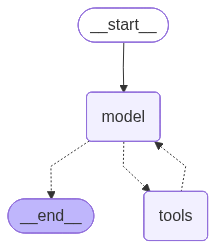

In [37]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [38]:
question = "How many products are there in the database?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many products are there in the database?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_Ctv5SwtsDmTXFJgGRNI9WkjX)
 Call ID: call_Ctv5SwtsDmTXFJgGRNI9WkjX
  Args:
    query: SELECT COUNT(product_id) AS total_products FROM products;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such column: product_id
[SQL: SELECT COUNT(product_id) AS total_products FROM products;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_Ipesjk5BOmVnkt7FM2PomWoJ)
 Call ID: call_Ipesjk5BOmVnkt7FM2PomWoJ
  Args:
    query: SELECT COUNT(*) AS total_products FROM products;
================================= Tool Message =================================
Na

In [40]:
question = "How many users are there in the database?"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many users are there in the database?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_YgyUExUtg1TNz6Smq114qBd5)
 Call ID: call_YgyUExUtg1TNz6Smq114qBd5
  Args:
    query: SELECT COUNT(user_id) AS user_count FROM users;
================================= Tool Message =================================
Name: execute_sql

[(100,)]
================================== Ai Message ==================================

There are 100 users in the database.
